In [73]:
import pandas as pd
import numpy as np

from data_preparation import DataProcessor

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
waste_data = pd.read_csv("synthetic_waste_data.csv")

In [75]:
def create_company_aggregated_timeseries(df, target_col='quantity_tons', date_col='date', company_col='company'):
    """
    Strategically aggregates time series data by company for multivariate LSTM modeling.
    
    This method transforms transactional data into a structured multivariate time series
    format where each company's volume becomes a distinct input channel, enabling the LSTM
    to capture inter-company dependencies and market dynamics.
    
    Parameters:
        df (pd.DataFrame): Source dataframe containing transaction records
        target_col (str): Column name containing the quantity to be aggregated
        date_col (str): Column name containing the date information
        company_col (str): Column name containing the company identifier
        
    Returns:
        pd.DataFrame: Time series dataframe with dates as index and companies as columns
    """
    # Ensure date column is in datetime format for proper aggregation
    df[date_col] = pd.to_datetime(df[date_col])
    
    # Strategic aggregation of quantity by date and company
    pivot_df = df.pivot_table(
        index=date_col,
        columns=company_col,
        values=target_col,
        aggfunc='sum',
        fill_value=0
    )
    
    # Ensure continuous daily dates (critical for LSTM sequence integrity)
    date_range = pd.date_range(start=pivot_df.index.min(), end=pivot_df.index.max())
    pivot_df = pivot_df.reindex(date_range, fill_value=0)
    
    # Add total market column for reference (strategic context)
    pivot_df['total_quantity_tons'] = pivot_df.sum(axis=1)
    
    # Ensure no NaN or infinite values that would disrupt LSTM training
    pivot_df = pivot_df.replace([np.inf, -np.inf], 0).fillna(0)
    
    return pivot_df

In [76]:
test =create_company_aggregated_timeseries(waste_data)
test

company,BuildRight Construction,CommercialServices Inc,GreenWaste Solutions,IndustrialProcess Ltd,MunicipalWaste Co,RegionalWaste Management,total_quantity_tons
2022-01-01,12.316680,0.000000,8.731023,80.975507,0.000000,51.828293,153.851503
2022-01-02,35.096189,73.952432,19.190867,117.606789,0.000000,0.000000,245.846278
2022-01-03,42.851899,84.851377,41.648117,141.703345,95.685231,167.399806,574.139774
2022-01-04,78.940950,65.642135,0.000000,134.639500,68.356149,98.875863,446.454597
2022-01-05,13.531711,47.343993,15.399205,0.000000,65.631546,0.000000,141.906455
...,...,...,...,...,...,...,...
2024-12-27,0.000000,174.242006,69.235744,164.490440,212.690136,244.488785,865.147110
2024-12-28,12.705529,0.000000,28.978614,98.126722,0.000000,112.837616,252.648480
2024-12-29,19.505244,0.000000,23.646943,29.275293,0.000000,0.000000,72.427480
2024-12-30,24.389950,41.156333,26.685827,69.664552,61.256699,84.249757,307.403118


In [77]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Parameters
hidden_size = 70
num_layers = 1
learning_rate = 0.001
sequence_length = 28
epochs = 80
batch_size = 16
train_ratio = 0.8


In [78]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define LSTM model
class MarketLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(MarketLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True, 
                            dropout=0.1 if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        forecast = self.fc(lstm_out[:, -1, :])
        return forecast

# Load data (assuming company_data is your DataFrame with companies and total_quantity_tons)
# Example: company_data = pd.read_csv('company_data.csv', index_col='date', parse_dates=True)


In [79]:

# Split into train and test sets
train_size = int(len(test) * train_ratio)
train_data = test.iloc[:train_size]
test_data = test.iloc[train_size:]

# Prepare data for LSTM
X_columns = [col for col in test.columns if col != 'total_quantity_tons']
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit scalers on training data only
X_train_data = train_data[X_columns].values
y_train_data = train_data['total_quantity_tons'].values.reshape(-1, 1)
X_train_scaled = scaler_X.fit_transform(X_train_data)
y_train_scaled = scaler_y.fit_transform(y_train_data)

# Create training sequences
X_train_seq, y_train_seq = [], []
for i in range(len(train_data) - sequence_length):
    X_train_seq.append(X_train_scaled[i:i+sequence_length])
    y_train_seq.append(y_train_scaled[i+sequence_length])

X_train_tensor = torch.FloatTensor(np.array(X_train_seq)).to(device)
y_train_tensor = torch.FloatTensor(np.array(y_train_seq)).to(device)



In [80]:
# Initialize and train model
input_size = len(X_columns)
model = MarketLSTM(input_size, hidden_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.6f}')



Epoch [10/80], Loss: 0.012488
Epoch [20/80], Loss: 0.009527
Epoch [30/80], Loss: 0.009421
Epoch [40/80], Loss: 0.009217
Epoch [50/80], Loss: 0.008584
Epoch [60/80], Loss: 0.008418
Epoch [70/80], Loss: 0.008042
Epoch [80/80], Loss: 0.007647


In [81]:
# Generate predictions on test data
model.eval()
X_test_data = test_data[X_columns].values
X_test_scaled = scaler_X.transform(X_test_data)
y_test = test_data['total_quantity_tons'].values[sequence_length:]

predictions = []
for i in range(len(test_data) - sequence_length):
    X_test_seq = X_test_scaled[i:i+sequence_length]
    X_test_tensor = torch.FloatTensor(X_test_seq).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(X_test_tensor)
        pred = scaler_y.inverse_transform(output.cpu().numpy())[0, 0]
        predictions.append(pred)



Test RMSE: 115.25


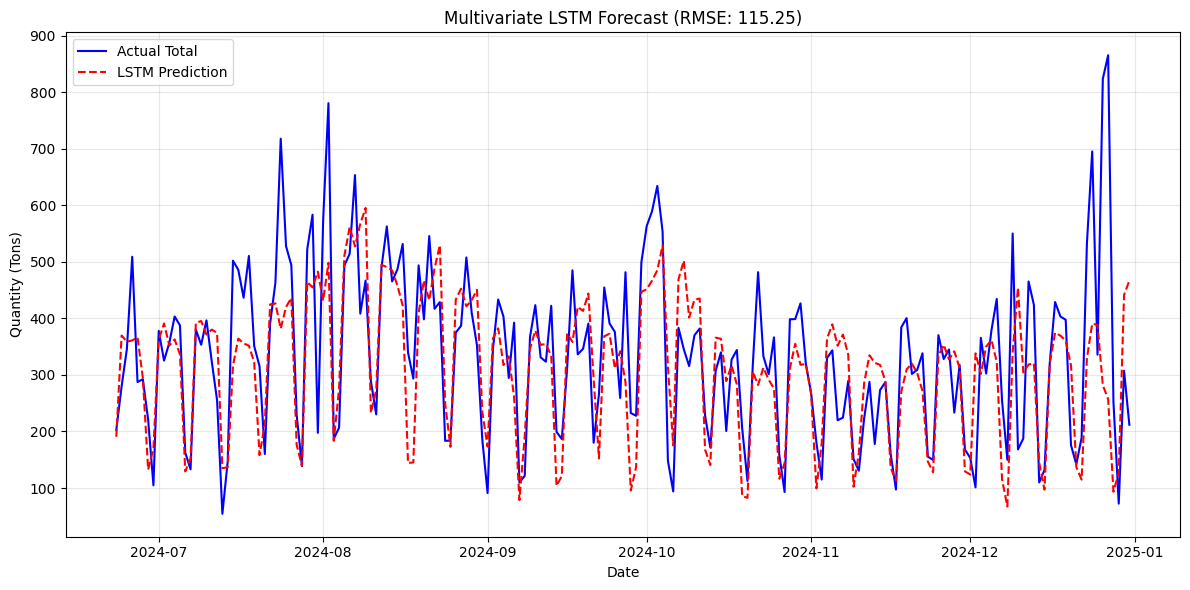

In [ ]:
# Calculate RMSE
rmse = np.sqrt(np.mean((np.array(predictions) - y_test)**2))
print(f"Test RMSE: {rmse:.2f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[sequence_length:], y_test, label='Actual Total', color='blue')
plt.plot(test_data.index[sequence_length:], predictions, label='LSTM Prediction', color='red', linestyle='--')
plt.title(f'Multivariate LSTM Forecast')
plt.xlabel('Date')
plt.ylabel('Quantity (Tons)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()